# Week 6

In [1]:
# =============================
# Standard Libraries
# =============================
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations
from joblib import parallel_backend
from tqdm.auto import tqdm
import kagglehub
from IPython.display import display
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import logging
logging.getLogger("optuna").setLevel(logging.WARNING)
import json
import re


# =============================
# Data Science Libraries
# =============================
import numpy as np
import pandas as pd
import optuna
import scipy.stats as stats
from scipy import sparse
from scipy.stats import loguniform, randint, uniform
from scipy.special import expit, logit


# =============================
# Visualization
# =============================
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker
import seaborn as sns

# =============================
# Scikit-learn
# =============================
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedKFold,
    ParameterGrid,
)
import sklearn.model_selection._search as sk_search
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeClassifier, LogisticRegression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
import sklearn.model_selection._validation as sk_validation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.exceptions import NotFittedError
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

import time
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.kernel_approximation import Nystroem
from sklearn.metrics import get_scorer, ConfusionMatrixDisplay

from sklearn import clone
from sklearn.model_selection import ParameterSampler

# local imports
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer


# =============================
# Global
# =============================
random_state = 42
N_ROWS = 1_000_000  # sample size for steam
pd.set_option("display.float_format", lambda x: f"{x:.6f}")

# =============================
# Utils
# =============================
def dollar_format(x, pos=None):
    return f"${x:,.0f}"

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

def try_read_csv(folder, fname, **kwargs):
    fp = os.path.join(folder, fname)
    return pd.read_csv(fp, **kwargs) if os.path.exists(fp) else None

def list_csvs(folder):
    # small guard to avoid errors if folder is missing
    if not os.path.exists(folder):
        return []
    return [f for f in os.listdir(folder) if f.lower().endswith(".csv")]

def simple_random_sample(df, n_rows=None, frac=None, random_state=42):
    if df is None:
        raise ValueError("df is None")
    n = len(df)
    if (n_rows is None) == (frac is None):
        raise ValueError("pass exactly one of n_rows or frac")
    if frac is not None:
        if not (0 < frac <= 1):
            raise ValueError("frac must be in (0, 1]")
        k = int(np.floor(frac * n))
    else:
        if int(n_rows) <= 0:
            raise ValueError("n_rows must be > 0")
        k = min(int(n_rows), n)
    if k >= n:
        return df.copy()
    t0 = time.perf_counter()
    rng = np.random.default_rng(random_state)
    idx = rng.choice(n, size=k, replace=False)
    out = df.iloc[idx].copy()
    t1 = time.perf_counter()
    print({"rows": n, "picked": int(len(out)), "frac": float(len(out) / n), "elapsed_sec": round(t1 - t0, 3)})
    return out

def stratified_sample(df, y, n_rows=None, frac=None, random_state=42):
    if df is None:
        raise ValueError("df is None")
    y_arr = df[y].to_numpy() if isinstance(y, str) else np.asarray(y)
    n = len(df)
    if len(y_arr) != n:
        raise ValueError("X and y length mismatch")
    if n_rows is not None and frac is not None:
        frac = None
    if n_rows is None and frac is None:
        raise ValueError("provide n_rows or frac")
    if frac is not None:
        if not (0 < frac <= 1):
            raise ValueError("frac must be in (0, 1]")
        test_size = float(frac)
        use_frac, use_n = frac, None
    else:
        if int(n_rows) <= 0:
            raise ValueError("n_rows must be > 0")
        test_size = min(float(n_rows) / n, 1.0)
        use_frac, use_n = None, int(n_rows)
    if test_size >= 1.0:
        return df.copy()
    _, counts = np.unique(y_arr, return_counts=True)
    if np.any(counts < 2):
        print("Warning: some classes <2 samples; using simple sampling.")
        return simple_random_sample(df, n_rows=use_n, frac=use_frac, random_state=random_state)
    t0 = time.perf_counter()
    idx = np.arange(n)
    _, test_idx, _, _ = train_test_split(
        idx, y_arr, test_size=test_size, stratify=y_arr, random_state=random_state
    )
    out = df.iloc[test_idx].copy()
    t1 = time.perf_counter()
    print(
        {
            "rows": n,
            "picked": int(len(out)),
            "frac": float(len(out) / n),
            "elapsed_sec": round(t1 - t0, 3),
            "mode": "stratified",
        }
    )
    return out

# =============================
# Memory Optimizer (improved)
# =============================
def optimize_dtypes(df, convert_categoricals=True, category_threshold=0.5):
    if df is None:
        return None

    start_bytes = int(df.memory_usage(deep=True).sum())

    # downcast numeric types
    for col in df.select_dtypes(include=[np.floating]).columns:
        df[col] = pd.to_numeric(df[col], downcast="float")
    for col in df.select_dtypes(include=[np.integer]).columns:
        df[col] = pd.to_numeric(df[col], downcast="integer")

    if convert_categoricals:
        obj_cols = df.select_dtypes(include=["object"]).columns
        n = max(len(df), 1)

        def is_unhashable_obj(x):
            return isinstance(x, (list, dict, set))

        for col in obj_cols:
            s = df[col]
            # skip columns that have unhashable values
            try:
                has_unhashable = s.apply(is_unhashable_obj).any()
            except Exception:
                has_unhashable = True
            if has_unhashable:
                continue

            # safe nunique for hashable objects
            try:
                unique_ratio = s.nunique(dropna=False) / n
            except TypeError:
                continue

            if unique_ratio <= category_threshold:
                try:
                    df[col] = df[col].astype("category")
                except Exception:
                    pass  # keep as object if conversion fails

    end_bytes = int(df.memory_usage(deep=True).sum())
    print({
        "memory_before_mb": round(start_bytes / (1024**2), 2),
        "memory_after_mb": round(end_bytes / (1024**2), 2),
        "saved_mb": round((start_bytes - end_bytes) / (1024**2), 2)
    })
    return df


# =============================
# Load Steam (sample first)
# =============================
steam_path = kagglehub.dataset_download("antonkozyriev/game-recommendations-on-steam")
print("Steam path:", steam_path, "\n", os.listdir(steam_path))

games = try_read_csv(steam_path, "games.csv", low_memory=False)
users = try_read_csv(steam_path, "users.csv", low_memory=False)
recommendations = try_read_csv(steam_path, "recommendations.csv", low_memory=False)

metadata = None
meta_fp = os.path.join(steam_path, "games_metadata.json")
if os.path.exists(meta_fp):
    metadata = pd.read_json(meta_fp, lines=True)

print(
    "Steam shapes:",
    {
        "games": None if games is None else games.shape,
        "users": None if users is None else users.shape,
        "recommendations": None if recommendations is None else recommendations.shape,
        "metadata": None if metadata is None else metadata.shape,
    },
)

steam = None
if recommendations is not None:
    # sample recommendations
    if "is_recommended" in recommendations.columns:
        recs_sample = stratified_sample(recommendations, y="is_recommended", n_rows=N_ROWS, random_state=random_state)
    else:
        recs_sample = simple_random_sample(recommendations, n_rows=N_ROWS, random_state=random_state)

    gm = games
    if metadata is not None and "app_id" in metadata.columns and games is not None and "app_id" in games.columns:
        gm = games.merge(metadata, on="app_id", how="left")

    steam = recs_sample
    if gm is not None and "app_id" in recs_sample.columns and "app_id" in gm.columns:
        steam = steam.merge(gm, on="app_id", how="left")
    if users is not None and "user_id" in steam.columns and "user_id" in users.columns:
        steam = steam.merge(users, on="user_id", how="left")

    print("steam:", steam.shape)

# =============================
# Load Olist (+ product-level review stats)
# =============================
olist_path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")
print("\nOlist path:", olist_path, "\n", os.listdir(olist_path))

olist_customers = try_read_csv(olist_path, "olist_customers_dataset.csv")
olist_geolocation = try_read_csv(olist_path, "olist_geolocation_dataset.csv")
olist_items = try_read_csv(olist_path, "olist_order_items_dataset.csv")
olist_payments = try_read_csv(olist_path, "olist_order_payments_dataset.csv")
olist_reviews = try_read_csv(olist_path, "olist_order_reviews_dataset.csv")
olist_orders = try_read_csv(olist_path, "olist_orders_dataset.csv")
olist_products = try_read_csv(olist_path, "olist_products_dataset.csv")
olist_sellers = try_read_csv(olist_path, "olist_sellers_dataset.csv")
olist_cat_trans = try_read_csv(olist_path, "product_category_name_translation.csv")

print(
    "Olist shapes:",
    {
        "customers": None if olist_customers is None else olist_customers.shape,
        "geolocation": None if olist_geolocation is None else olist_geolocation.shape,
        "items": None if olist_items is None else olist_items.shape,
        "payments": None if olist_payments is None else olist_payments.shape,
        "reviews": None if olist_reviews is None else olist_reviews.shape,
        "orders": None if olist_orders is None else olist_orders.shape,
        "products": None if olist_products is None else olist_products.shape,
        "sellers": None if olist_sellers is None else olist_sellers.shape,
        "category_translation": None if olist_cat_trans is None else olist_cat_trans.shape,
    },
)

# Build product-level review statistics
prod_reviews = None
prod_stats = None
if (olist_items is not None) and (olist_reviews is not None):
    # join reviews to items by order_id to know which product each review belongs to
    prod_reviews = (
        olist_items[["order_id", "product_id"]]
        .merge(olist_reviews[["order_id", "review_score", "review_id"]], on="order_id", how="inner")
    )
    # aggregate per product
    prod_stats = (
        prod_reviews.groupby("product_id", as_index=False)
        .agg(
            review_count_product=("review_score", "count"),
            review_score_mean_product=("review_score", "mean")
        )
    )

olist = None
if all(x is not None for x in [olist_orders, olist_customers, olist_items, olist_products, olist_sellers]):
    # translated category names
    if olist_cat_trans is not None and "product_category_name" in olist_products.columns:
        products_en = olist_products.merge(olist_cat_trans, on="product_category_name", how="left")
    else:
        products_en = olist_products

    # enrich items with product and seller info
    items_ext = (
        olist_items.merge(products_en, on="product_id", how="left")
        .merge(olist_sellers, on="seller_id", how="left", suffixes=("", "_seller"))
    )

    # average lat,lng per ZIP prefix
    if olist_geolocation is not None:
        geo_zip = (
            olist_geolocation.groupby("geolocation_zip_code_prefix", as_index=False).agg(
                geolocation_lat=("geolocation_lat", "mean"),
                geolocation_lng=("geolocation_lng", "mean"),
                geo_points=("geolocation_city", "count"),
            )
        )
        customers_geo = (
            olist_customers.merge(
                geo_zip,
                left_on="customer_zip_code_prefix",
                right_on="geolocation_zip_code_prefix",
                how="left",
            )
            .drop(columns=["geolocation_zip_code_prefix"])
        )
    else:
        customers_geo = olist_customers

    payments_agg = (
        olist_payments.groupby("order_id", as_index=False).agg(
            payment_value_total=("payment_value", "sum"),
            payment_installments_max=("payment_installments", "max"),
            payment_count=("payment_type", "count"),
        )
        if olist_payments is not None
        else None
    )

    # assemble main olist table
    olist = (
        olist_orders.merge(customers_geo, on="customer_id", how="left")
        .merge(items_ext, on="order_id", how="left")
    )

    if payments_agg is not None:
        olist = olist.merge(payments_agg, on="order_id", how="left")

    # merge product-level review stats on product_id
    if prod_stats is not None:
        olist = olist.merge(prod_stats, on="product_id", how="left")

    print("olist:", olist.shape)

    # sample Olist
    olist = simple_random_sample(olist, n_rows=N_ROWS, random_state=random_state)
    print("olist sample:", olist.shape)

# Build a simple binary target: product avg >= 4.0 and enough reviews
if olist is not None:
    min_reviews = 10
    olist["y_is_4_plus"] = (
        (olist["review_score_mean_product"] >= 4.0) &
        (olist["review_count_product"] >= min_reviews)
    ).astype("int8")

# Run immediately after loading/creating `olist`
base_cols = [
    "order_id","customer_id","order_status","order_purchase_timestamp",
    "order_approved_at","order_delivered_carrier_date",
    "order_delivered_customer_date","order_estimated_delivery_date",
    "customer_unique_id","customer_zip_code_prefix","customer_city",
    "customer_state","geolocation_lat","geolocation_lng","geo_points",
    "order_item_id","product_id","seller_id","shipping_limit_date","price",
    "freight_value","product_category_name","product_name_lenght",
    "product_description_lenght","product_photos_qty","product_weight_g",
    "product_length_cm","product_height_cm","product_width_cm",
    "product_category_name_english","seller_zip_code_prefix","seller_city",
    "seller_state","payment_value_total","payment_installments_max",
    "payment_count","review_score_mean_product","review_count_product"
]

if olist is not None:
    idx_map = {}
    cols_set = set(olist.columns)
    # map numbered columns (if present) to the expected names
    for i, target_name in enumerate(base_cols):
        if target_name in cols_set:
            idx_map[target_name] = target_name  # keep as-is
        if str(i) in cols_set:
            idx_map[str(i)] = target_name       # rename "0","1",...
    olist = olist.rename(columns=idx_map)


# =============================
# Load Video Games Sales 2019
# =============================
vg2019_path = kagglehub.dataset_download("ashaheedq/video-games-sales-2019")
print("\nVG2019 path:", vg2019_path, "\n", os.listdir(vg2019_path))

sales = None
csvs = list_csvs(vg2019_path)
target_csv = "vgsales-12-4-2019.csv" if "vgsales-12-4-2019.csv" in csvs else (csvs[0] if csvs else None)
if target_csv is not None:
    sales = pd.read_csv(os.path.join(vg2019_path, target_csv), low_memory=False)
    print("sales:", sales.shape, "| file:", target_csv)

    # sample VG2019
    if "Genre" in sales.columns:
        sales = stratified_sample(sales, y="Genre", n_rows=N_ROWS, random_state=random_state)
    else:
        sales = simple_random_sample(sales, n_rows=N_ROWS, random_state=random_state)
    print("sales sample:", sales.shape)
else:
    print("No CSV found in the video-games-sales-2019 dataset.")


# =============================
# Final summaries (with downcasting)
# =============================
if steam is not None:
    print("\nOptimizing dtypes for steam...")
    steam = optimize_dtypes(steam, convert_categoricals=True)

if olist is not None:
    print("\nOptimizing dtypes for olist...")
    olist = optimize_dtypes(olist, convert_categoricals=True)

if sales is not None:
    print("\nOptimizing dtypes for sales...")
    sales = optimize_dtypes(sales, convert_categoricals=True)

print("\nsteam sample:", None if steam is None else steam.shape)
print("olist sample:", None if olist is None else olist.shape)
print("sales sample:", None if sales is None else sales.shape)


Steam path: /Users/chandlercampbell/.cache/kagglehub/datasets/antonkozyriev/game-recommendations-on-steam/versions/28 
 ['recommendations.csv', 'users.csv', 'games.csv', 'games_metadata.json']
Steam shapes: {'games': (50872, 13), 'users': (14306064, 3), 'recommendations': (41154794, 8), 'metadata': (50872, 3)}
{'rows': 41154794, 'picked': 1000001, 'frac': 0.02429853008133147, 'elapsed_sec': 5.864, 'mode': 'stratified'}
steam: (1000001, 24)

Olist path: /Users/chandlercampbell/.cache/kagglehub/datasets/olistbr/brazilian-ecommerce/versions/2 
 ['olist_sellers_dataset.csv', 'product_category_name_translation.csv', 'olist_orders_dataset.csv', 'olist_order_items_dataset.csv', 'olist_customers_dataset.csv', 'olist_geolocation_dataset.csv', 'olist_order_payments_dataset.csv', 'olist_order_reviews_dataset.csv', 'olist_products_dataset.csv']
Olist shapes: {'customers': (99441, 5), 'geolocation': (1000163, 5), 'items': (112650, 7), 'payments': (103886, 5), 'reviews': (99224, 7), 'orders': (99441

In [2]:
def prepare_all(
    steam, olist, sales,
    top_k_tags=200, max_total_features=400,
    test_size=0.2, random_state=42,
    balance_method="auto",
    min_class_ratio=0.5,
    feature_select_method="none",
    feature_select_k=200
):
    # ---------- helpers ----------
    def drop_known_leaks_from_features(X_in, y_in=None):
        leak_names = {"y_is_4_plus", "delivered_late", "target", "label", "target_olist", "target_sales"}
        to_drop = [c for c in X_in.columns if (c in leak_names) or c.lower().startswith("target") or c.lower().startswith("label")]
        X_in = X_in.drop(columns=to_drop, errors="ignore")

        # simple exact-leak check for binary columns
        if y_in is not None:
            y_series = pd.Series(y_in).reset_index(drop=True)
            for c in list(X_in.columns):
                xc = pd.Series(X_in[c]).reset_index(drop=True)
                try:
                    ux = set(pd.unique(xc.dropna()))
                    uy = set(pd.unique(y_series.dropna()))
                    if ux <= {0, 1} and uy <= {0, 1}:
                        if (xc.astype("int8") == y_series.astype("int8")).all():
                            X_in = X_in.drop(columns=[c])
                except Exception:
                    pass
        return X_in

    def resample_binary(Xb, yb, method="oversample", random_state=42):
        counts = yb.value_counts(dropna=False)
        if counts.shape[0] != 2:
            return Xb, yb
        majority_class = counts.idxmax()
        minority_class = counts.idxmin()
        majority_idx = yb[yb == majority_class].index.values
        minority_idx = yb[yb == minority_class].index.values
        rng = np.random.RandomState(random_state)
        if method == "undersample":
            keep_majority = rng.choice(majority_idx, size=len(minority_idx), replace=False)
            new_index = np.concatenate([minority_idx, keep_majority])
        else:
            need = int(len(majority_idx) - len(minority_idx))
            need = max(0, need)
            add_minority = rng.choice(minority_idx, size=need, replace=True)
            new_index = np.concatenate([majority_idx, minority_idx, add_minority])
        rng.shuffle(new_index)
        Xb2 = Xb.loc[new_index].reset_index(drop=True)
        yb2 = yb.loc[new_index].reset_index(drop=True)
        return Xb2, yb2

    def split_and_balance(df_in, target_col, balance_method, min_class_ratio, random_state):
        X_in = df_in.drop(columns=[target_col]).copy()
        y_in = df_in[target_col].astype(int)

        # drop leaks before splitting
        X_in = drop_known_leaks_from_features(X_in, y_in)

        # simple NA handling
        for c in X_in.columns:
            if pd.api.types.is_numeric_dtype(X_in[c]):
                X_in[c] = X_in[c].fillna(X_in[c].median())
            else:
                X_in[c] = X_in[c].astype("string").fillna("Unknown")

        if y_in.nunique() == 2:
            X_tr, X_te, y_tr, y_te = train_test_split(
                X_in, y_in, test_size=test_size, random_state=random_state, stratify=y_in
            )
        else:
            raise ValueError(f"{target_col}: target must have 2 classes. Check target construction.")

        vc = y_tr.value_counts()
        if vc.shape[0] == 2:
            ratio = float(vc.min()) / float(vc.max()) if vc.max() > 0 else 1.0
            if balance_method != "none" and ratio < min_class_ratio:
                method = (
                    "oversample" if balance_method == "auto" and len(X_tr) <= 200000
                    else ("undersample" if balance_method == "auto" else balance_method)
                )
                X_tr, y_tr = resample_binary(X_tr, y_tr, method=method, random_state=random_state)

        print(f"{target_col} train class counts:", y_tr.value_counts().to_dict())
        print(f"{target_col} test class counts:", y_te.value_counts().to_dict())
        return X_tr, X_te, y_tr, y_te

    def apply_feature_selection(X_tr, y_tr, X_te, method, k, random_state):
        if method == "none":
            return X_tr, X_te
        n_features = X_tr.shape[1]
        if n_features <= 1 or k >= n_features:
            return X_tr, X_te
        k = int(max(1, min(k, n_features)))
        try:
            if method == "mi":
                selector = SelectKBest(score_func=mutual_info_classif, k=k)
                selector.fit(X_tr, y_tr)
                kept_cols = X_tr.columns[selector.get_support()].tolist()
            elif method == "rf":
                rf = RandomForestClassifier(
                    n_estimators=300, random_state=random_state, n_jobs=-1,
                    class_weight="balanced_subsample"
                )
                rf.fit(X_tr, y_tr)
                order = np.argsort(rf.feature_importances_)[::-1][:k]
                kept_cols = X_tr.columns[order].tolist()
            else:
                print("Unknown feature_select_method. Skipping selection.")
                return X_tr, X_te
            return X_tr[kept_cols].copy(), X_te[kept_cols].copy()
        except Exception as e:
            print(f"Feature selection error ({method}): {e}. Using all features.")
            return X_tr, X_te

    # ---------- steam ----------
    def prepare_steam_df(steam_in):
        df = steam_in.copy()

        for col in ["title", "description", "tags"]:
            if col in df.columns:
                df[col] = df[col].astype("string")

        def safe_to_datetime(series):
            return pd.to_datetime(series.astype("string"), errors="coerce")

        need = [
            "date","date_release","title","description","price_final","price_original","tags",
            "win","mac","linux","steam_deck","hours","products","reviews","is_recommended",
            "helpful","funny","positive_ratio","user_reviews","rating","app_id","user_id","review_id"
        ]
        for c in need:
            if c not in df.columns:
                df[c] = np.nan

        df["date"] = safe_to_datetime(df["date"])
        df["date_release"] = safe_to_datetime(df["date_release"])

        df["days_since_release"] = (df["date"] - df["date_release"]).dt.days
        df["days_since_release"] = df["days_since_release"].clip(lower=0).fillna(0)
        df["review_year"] = df["date"].dt.year.fillna(0)
        df["review_month"] = df["date"].dt.month.fillna(0)
        df["review_dow"] = df["date"].dt.dayofweek.fillna(0)

        df["title_len"] = df["title"].astype("string").str.len().fillna(0).astype("int32")
        df["desc_len"]  = df["description"].astype("string").str.len().fillna(0).astype("int32")

        for col in ["hours","products","reviews","price_final","price_original"]:
            df[col] = pd.to_numeric(df[col], errors="coerce")
            df[col + "_log1p"] = np.log1p(df[col])

        df["is_free"] = (df["price_final"] == 0).astype("int8")
        with np.errstate(divide="ignore", invalid="ignore"):
            ratio = 1.0 - (df["price_final"] / df["price_original"])
        df["discount_ratio"] = pd.Series(ratio).clip(0, 1).fillna(0.0)

        for b in ["win","mac","linux","steam_deck"]:
            df[b] = (df[b] == True).astype("int8")

        if df["is_recommended"].dtype == bool:
            y = df["is_recommended"].astype("int8")
        else:
            text = df["is_recommended"].astype(str).str.lower().str.strip()
            y = np.where(text.isin(["1","true","yes","y","recommended"]), 1, 0).astype("int8")

        keep_dense = [
            "win","mac","linux","steam_deck",
            "days_since_release","review_year","review_month","review_dow",
            "title_len","desc_len",
            "hours_log1p","products_log1p","reviews_log1p",
            "price_final_log1p","price_original_log1p",
            "discount_ratio","is_free"
        ]
        X = df[keep_dense].copy()

        base_cols = X.shape[1]
        allowed_tag_cols = max(0, min(top_k_tags, max_total_features - base_cols))
        if allowed_tag_cols > 0:
            tags_clean = (
                df["tags"].astype("string").fillna("").str.lower()
                  .str.replace(r"[\[\]\"]", "", regex=True)
                  .str.replace(";", ",").str.replace("/", ",")
            )
            vec = CountVectorizer(
                tokenizer=lambda s: [t.strip() for t in s.split(",") if t.strip()],
                lowercase=False, binary=True, max_features=allowed_tag_cols
            )
            tag_sparse = vec.fit_transform(tags_clean.values)
            tag_df = pd.DataFrame(
                tag_sparse.toarray(),
                columns=[f"tag_{t}" for t in vec.get_feature_names_out()],
                index=df.index
            )
            X = pd.concat([X, tag_df], axis=1)

        for c in X.columns:
            if pd.api.types.is_numeric_dtype(X[c]):
                X[c] = X[c].fillna(X[c].median())
            else:
                X[c] = X[c].astype("string").fillna("")

        raw = df[["date","app_id"]].copy()
        y = pd.Series(y, index=df.index, name="target_steam")

        steam_df = X.copy()
        steam_df["target_steam"] = y
        steam_df = steam_df[steam_df["target_steam"].notna()].copy()
        steam_df["target_steam"] = steam_df["target_steam"].astype("int8")
        return steam_df, raw

    # ---------- olist ----------
    def prepare_olist_df(olist_in):
        o = olist_in.copy()

        def safe_to_datetime(series):
            return pd.to_datetime(series.astype("string"), errors="coerce")

        date_cols = [
            "order_purchase_timestamp","order_approved_at","order_delivered_carrier_date",
            "order_delivered_customer_date","order_estimated_delivery_date","shipping_limit_date",
        ]
        for c in date_cols:
            o[c] = safe_to_datetime(o[c]) if c in o.columns else pd.NaT

        # simple time parts
        o["purchase_dayofweek"] = o["order_purchase_timestamp"].dt.dayofweek
        o["purchase_month"] = o["order_purchase_timestamp"].dt.month
        o["purchase_hour"] = o["order_purchase_timestamp"].dt.hour

        def to_hours(td):
            return td.dt.total_seconds() / 3600.0

        # coerce numeric cols before math
        for c in ["product_length_cm","product_width_cm","product_height_cm","product_weight_g",
                  "payment_installments_max","payment_value_total","payment_count","freight_value","order_item_id"]:
            if c in o.columns:
                o[c] = pd.to_numeric(o[c], errors="coerce")

        o["approval_delay_h"] = to_hours(o["order_approved_at"] - o["order_purchase_timestamp"])
        o["to_carrier_h"] = to_hours(o["order_delivered_carrier_date"] - o["order_purchase_timestamp"])
        o["to_customer_h"] = to_hours(o["order_delivered_customer_date"] - o["order_purchase_timestamp"])
        o["est_delivery_h"] = to_hours(o["order_estimated_delivery_date"] - o["order_purchase_timestamp"])
        o["limit_from_purchase_h"] = to_hours(o["shipping_limit_date"] - o["order_purchase_timestamp"])

        # this is only for fallback label logic, not a feature
        o["delivered_late"] = (o["order_delivered_customer_date"] > o["order_estimated_delivery_date"]).astype("Int64")

        # product shape features
        for c in ["product_length_cm","product_width_cm","product_height_cm","product_weight_g"]:
            if c not in o.columns:
                o[c] = np.nan
        o["product_volume_cm3"] = o["product_length_cm"] * o["product_width_cm"] * o["product_height_cm"]
        o["density_g_per_cm3"] = np.where(
            (o["product_volume_cm3"] > 0) & o["product_weight_g"].notna(),
            o["product_weight_g"] / o["product_volume_cm3"],
            np.nan,
        )

        # payments
        for c in ["payment_installments_max","payment_value_total","payment_count"]:
            if c not in o.columns:
                o[c] = np.nan
        o["avg_installment_value"] = np.where(
            pd.to_numeric(o["payment_installments_max"], errors="coerce") > 0,
            o["payment_value_total"] / o["payment_installments_max"],
            np.nan,
        )
        o["payment_value_per_payment"] = np.where(
            pd.to_numeric(o["payment_count"], errors="coerce") > 0,
            o["payment_value_total"] / o["payment_count"],
            np.nan,
        )

        # freight
        if "freight_value" not in o.columns:
            o["freight_value"] = np.nan
        o["freight_per_kg"] = np.where(
            pd.to_numeric(o["product_weight_g"], errors="coerce") > 0,
            o["freight_value"] / (o["product_weight_g"] / 1000.0),
            np.nan,
        )

        if "order_item_id" not in o.columns:
            o["order_item_id"] = 1
        o["is_multi_item_order"] = (pd.to_numeric(o["order_item_id"], errors="coerce") > 1).astype("Int64")

        # category merge (string-safe)
        if "product_category_name" in o.columns:
            o["product_category_name"] = o["product_category_name"].astype("string")
        if "product_category_name_english" in o.columns:
            o["product_category_name_english"] = o["product_category_name_english"].astype("string")
        if "product_category_name" in o.columns and "product_category_name_english" in o.columns:
            s1 = o["product_category_name_english"]
            s2 = o["product_category_name"]
            o["product_category"] = s1.mask(s1.isna() | (s1 == ""), s2)
            o = o.drop(columns=["product_category_name","product_category_name_english"])
        elif "product_category_name_english" in o.columns:
            o["product_category"] = o["product_category_name_english"]
            o = o.drop(columns=["product_category_name_english"])
        elif "product_category_name" in o.columns:
            o["product_category"] = o["product_category_name"]
            o = o.drop(columns=["product_category_name"])
        else:
            o["product_category"] = "Unknown"

        # city frequencies
        for col in ["customer_city","seller_city"]:
            if col in o.columns:
                s_ = o[col].astype("string").fillna("Unknown")
                freq = s_.map(s_.value_counts(normalize=True))
                o[col + "_freq"] = freq.astype(float)
                o = o.drop(columns=[col])

        # one-hot
        cat_cols = []
        for c in ["order_status","customer_state","seller_state","product_category"]:
            if c in o.columns:
                cat_cols.append(c)
                o[c] = o[c].astype("string").fillna("Unknown")
        if cat_cols:
            o = pd.get_dummies(o, columns=cat_cols, dtype=np.uint8)

        # target with fallback
        has_prod_cols = all(c in olist_in.columns for c in ["review_score_mean_product", "review_count_product"])
        if has_prod_cols:
            mean_prod = pd.to_numeric(olist_in["review_score_mean_product"], errors="coerce")
            count_prod = pd.to_numeric(olist_in["review_count_product"], errors="coerce").fillna(0)
            min_reviews = 10
            y = ((mean_prod >= 4.0) & (count_prod >= min_reviews)).astype("Int64")
            if y.dropna().nunique() < 2:
                y = (pd.to_numeric(olist_in["review_score_mean_product"], errors="coerce") >= 3.5).astype("Int64")
        else:
            y = o["delivered_late"].copy()

        o["target_olist"] = y
        o = o[o["target_olist"].notna()].copy()
        o["target_olist"] = o["target_olist"].astype("int8")

        # remove leaks
        for leak_col in ["review_score_mean_product","review_count_product","review_score_mean","delivered_late"]:
            if leak_col in o.columns:
                o = o.drop(columns=[leak_col])

        # drop ids and dates
        drop_ids = ["order_id","customer_id","customer_unique_id","product_id","seller_id"]
        o = o.drop(columns=[c for c in drop_ids if c in o.columns], errors="ignore")
        o = o.drop(columns=[c for c in date_cols if c in o.columns], errors="ignore")

        # final NA handling
        num_cols = o.select_dtypes(include=[np.number]).columns.tolist()
        num_cols_no_target = [c for c in num_cols if c != "target_olist"]
        for c in num_cols_no_target:
            o[c] = o[c].fillna(o[c].median())

        obj_cols = o.select_dtypes(include=["object"]).columns.tolist()
        for c in obj_cols:
            o[c] = o[c].astype("string").fillna("Unknown")

        return o.copy()

    # ---------- sales ----------
    def prepare_sales_df(sales_in):
        s = sales_in.copy()

        # robust target with fallbacks
        y = None
        if "Critic_Score" in s.columns:
            critic = pd.to_numeric(s["Critic_Score"], errors="coerce")
            y = (critic >= 80).astype("Int64")
        if y is None or y.dropna().nunique() < 2:
            if "User_Score" in s.columns:
                user = pd.to_numeric(s["User_Score"], errors="coerce")
                y = (user >= 8).astype("Int64")
        if y is None or y.dropna().nunique() < 2:
            if "Global_Sales" in s.columns:
                gs = pd.to_numeric(s["Global_Sales"], errors="coerce")
                thresh = np.nanpercentile(gs, 70)
                y = (gs >= thresh).astype("Int64")

        if y is None:
            s["target_sales"] = pd.Series(np.nan, index=s.index)
        else:
            s["target_sales"] = y

        s = s[s["target_sales"].notna()].copy()
        s["target_sales"] = s["target_sales"].astype("int8")

        # remove leaks and junk
        leak_cols = ["NA_Sales","PAL_Sales","JP_Sales","Other_Sales","Total_Shipped","Rank","Global_Sales"]
        junk_cols = ["VGChartz_Score","Vgchartzscore","url","img_url","status",
                     "Last_Update","basename","User_Score","Critic_Score"]
        s = s.drop(columns=[c for c in leak_cols + junk_cols if c in s.columns], errors="ignore")

        # simple text flag
        if "Name" in s.columns:
            terms = ["remaster","remastered","hd","definitive","collection","trilogy","anniversary"]
            s["is_remaster"] = s["Name"].astype("string").str.lower().str.contains("|".join(terms), na=False).astype("Int64")
            s = s.drop(columns=["Name"])
        else:
            s["is_remaster"] = pd.Series(0, index=s.index, dtype="Int64")

        # platform family
        def platform_family(p):
            p = "" if pd.isna(p) else str(p).upper()
            if p.startswith("PS") or p in {"PSP","PSV"}: return "PlayStation"
            if p.startswith("X") or p in {"XB","XBLA"}: return "Xbox"
            if p in {"SWITCH","WII","WIIU","GC","N64","SNES","NES","DS","3DS","GB","GBC","GBA"}: return "Nintendo"
            if p == "PC": return "PC"
            if p in {"DC","DREAMCAST","SAT","GEN","MD","MEGADRIVE","GG"}: return "Sega"
            if "ATARI" in p: return "Atari"
            return "Other"

        if "Platform" in s.columns:
            s["Platform_Family"] = s["Platform"].apply(platform_family)
            handhelds = {"DS","3DS","GB","GBC","GBA","PSP","PSV"}
            s["is_portable"] = s["Platform"].astype("string").str.upper().isin(handhelds).astype("Int64")
            s = s.drop(columns=["Platform"])
        else:
            s["Platform_Family"] = "Other"
            s["is_portable"] = pd.Series(0, index=s.index, dtype="Int64")

        # year and decade
        if "Year" in s.columns:
            s["Year"] = pd.to_numeric(s["Year"], errors="coerce")
            s.loc[~s["Year"].between(1970, 2025, inclusive="both"), "Year"] = np.nan
            s["Decade"] = (s["Year"] // 10 * 10).astype("Int64").astype(str)
        else:
            s["Year"] = np.nan
            s["Decade"] = "<NA>"

        # publisher/dev freq
        for col in ["Publisher","Developer"]:
            if col in s.columns:
                series = s[col].astype("string").fillna("Unknown")
                freq = series.map(series.value_counts(normalize=True))
                s[col + "_freq"] = freq.astype(float)
                s = s.drop(columns=[col])

        # one-hot
        cat_cols = []
        for c in ["Genre","ESRB_Rating","Platform_Family","Decade"]:
            if c in s.columns:
                cat_cols.append(c)
                s[c] = s[c].astype("string").fillna("Unknown")
        if cat_cols:
            s = pd.get_dummies(s, columns=cat_cols, dtype=np.uint8)

        # final NA handling
        num_cols = s.select_dtypes(include=[np.number]).columns.tolist()
        num_cols_no_target = [c for c in num_cols if c != "target_sales"]
        for c in num_cols_no_target:
            s[c] = s[c].fillna(s[c].median())

        obj_cols = s.select_dtypes(include=["object"]).columns.tolist()
        for c in obj_cols:
            s[c] = s[c].astype("string").fillna("Unknown")

        return s.copy()

    # ---------- build ----------
    steam_df, steam_raw = prepare_steam_df(steam)
    olist_df = prepare_olist_df(olist)
    sales_df = prepare_sales_df(sales)

    # ---------- steam split: time-based, grouped by app ----------
    full_raw = steam_raw.copy()
    full_raw["date"] = pd.to_datetime(full_raw["date"].astype("string"), errors="coerce")
    cutoff_q = 1.0 - float(test_size)
    cutoff_date = full_raw["date"].sort_values().quantile(cutoff_q)

    grp_first = full_raw.groupby("app_id")["date"].min()
    app_train = set(grp_first[grp_first <= cutoff_date].index.tolist())
    app_test = set(grp_first[grp_first > cutoff_date].index.tolist())

    is_train_mask = full_raw["app_id"].isin(app_train)
    is_test_mask = full_raw["app_id"].isin(app_test)
    is_train_mask = is_train_mask | (~(is_train_mask | is_test_mask))

    Xs = steam_df.drop(columns=["target_steam"])
    ys = steam_df["target_steam"].astype(int)

    X_train_steam = Xs[is_train_mask].reset_index(drop=True)
    X_test_steam = Xs[is_test_mask].reset_index(drop=True)
    y_train_steam = ys[is_train_mask].reset_index(drop=True)
    y_test_steam = ys[is_test_mask].reset_index(drop=True)

    print("steam cutoff_date:", pd.to_datetime(cutoff_date))
    print("steam train rows:", int(X_train_steam.shape[0]), "| test rows:", int(X_test_steam.shape[0]))
    print("steam y_train counts:", y_train_steam.value_counts().to_dict())
    print("steam y_test counts:", y_test_steam.value_counts().to_dict())

    if y_train_steam.nunique() == 2:
        vc = y_train_steam.value_counts()
        ratio = float(vc.min()) / float(vc.max()) if vc.max() > 0 else 1.0
        if balance_method != "none" and ratio < min_class_ratio:
            method = "oversample" if (balance_method == "auto" and len(X_train_steam) <= 200000) else \
                     ("undersample" if balance_method == "auto" else balance_method)
            X_train_steam, y_train_steam = resample_binary(X_train_steam, y_train_steam, method=method, random_state=random_state)
            print("steam balanced train counts:", y_train_steam.value_counts().to_dict())

    steam_split = (X_train_steam, X_test_steam, y_train_steam, y_test_steam)

    # ---------- standard splits ----------
    olist_split = split_and_balance(olist_df, "target_olist", balance_method, min_class_ratio, random_state)
    sales_split = split_and_balance(sales_df, "target_sales", balance_method, min_class_ratio, random_state)

    # ---------- optional feature selection ----------
    if feature_select_method != "none":
        Xtr, Xte, ytr, yte = steam_split
        Xtr_s, Xte_s = apply_feature_selection(Xtr, ytr, Xte, feature_select_method, feature_select_k, random_state)
        steam_split = (Xtr_s, Xte_s, ytr, yte)

        Xtr, Xte, ytr, yte = olist_split
        Xtr_o, Xte_o = apply_feature_selection(Xtr, ytr, Xte, feature_select_method, feature_select_k, random_state)
        olist_split = (Xtr_o, Xte_o, ytr, yte)

        Xtr, Xte, ytr, yte = sales_split
        Xtr_v, Xte_v = apply_feature_selection(Xtr, ytr, Xte, feature_select_method, feature_select_k, random_state)
        sales_split = (Xtr_v, Xte_v, ytr, yte)

    print("\nsteam selected features (train, test):", steam_split[0].shape[1], steam_split[1].shape[1])
    print("olist selected features (train, test):", olist_split[0].shape[1], olist_split[1].shape[1])
    print("sales selected features (train, test):", sales_split[0].shape[1], sales_split[1].shape[1])

    return {
        "steam": steam_split,
        "olist": olist_split,
        "sales": sales_split,
        "feature_names": {
            "steam": steam_split[0].columns.tolist(),
            "olist": olist_split[0].columns.tolist(),
            "sales": sales_split[0].columns.tolist(),
        }
    }


In [3]:
splits = prepare_all(
    steam, olist, sales,
    test_size=0.2,
    random_state=42,
    balance_method="auto",
    min_class_ratio=0.5,
    feature_select_method="rf",
    feature_select_k=50
)

X_train_steam, X_test_steam, y_train_steam, y_test_steam = splits["steam"]
X_train_olist, X_test_olist, y_train_olist, y_test_olist = splits["olist"]
X_train_sales, X_test_sales, y_train_sales, y_test_sales = splits["sales"]

steam cutoff_date: 2022-02-17 00:00:00
steam train rows: 955509 | test rows: 44492
steam y_train counts: {1: 821239, 0: 134270}
steam y_test counts: {1: 36606, 0: 7886}
steam balanced train counts: {1: 134270, 0: 134270}
target_olist train class counts: {1: 66112, 0: 66112}
target_olist test class counts: {0: 16528, 1: 6157}
target_sales train class counts: {1: 44438, 0: 44438}
target_sales test class counts: {0: 11110, 1: 49}

steam selected features (train, test): 50 50
olist selected features (train, test): 50 50
sales selected features (train, test): 47 47


In [4]:
# Helper to probe float parameters
def float_range(start, stop, step):
    vals = []
    x = start
    while x <= stop:
        vals.append(x)
        x += step
    return vals

# Steam Reviews


Steam Decision Tree CV F1 Macro: 0.6295 ± 0.0019

Top 10 Steam feature importances:
 hours_log1p          0.213903
products_log1p       0.132952
days_since_release   0.128454
reviews_log1p        0.085958
review_month         0.061086
title_len            0.057524
review_dow           0.053625
price_final_log1p    0.050606
review_year          0.044196
desc_len             0.027426
dtype: float64


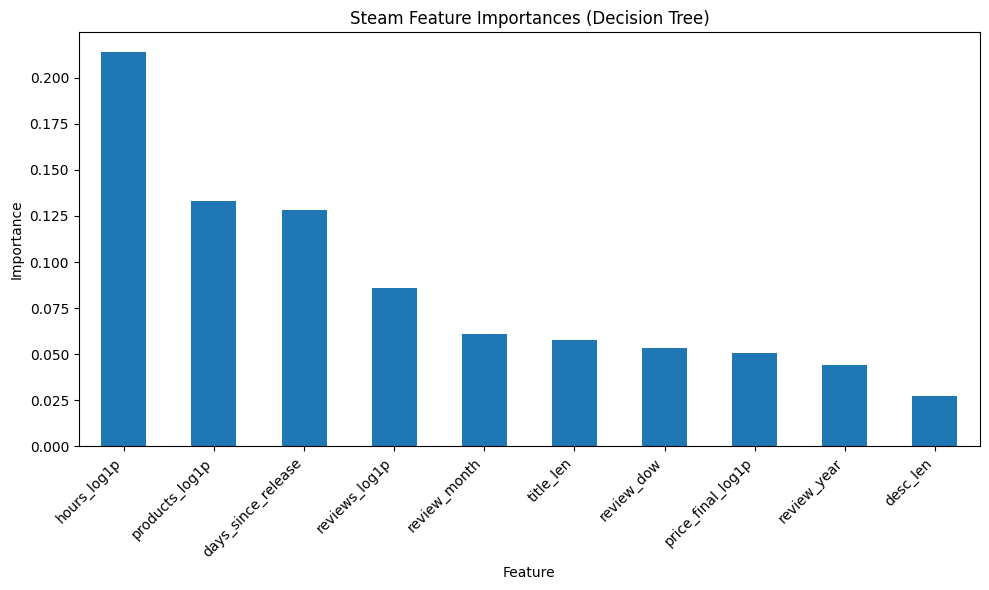

In [5]:
# Baseline Steam decision tree classifier

dt_steam = DecisionTreeClassifier(random_state=random_state)
steam_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=random_state)
dt_steam_scores = cross_val_score(dt_steam, X_train_steam, y_train_steam, cv=steam_cv, scoring="f1_macro", n_jobs=-1)
print(f"\nSteam Decision Tree CV F1 Macro: {dt_steam_scores.mean():.4f} ± {dt_steam_scores.std():.4f}")
dt_steam.fit(X_train_steam, y_train_steam)

steam_X_df = pd.DataFrame(X_train_steam, columns=X_train_steam.columns)
importances = pd.Series(dt_steam.feature_importances_, index=steam_X_df.columns).sort_values(ascending=False)
print("\nTop 10 Steam feature importances:\n", importances.head(10))

importances.head(10).plot(kind="bar", figsize=(10, 6), title="Steam Feature Importances (Decision Tree)")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Steam Random Forest CV F1 Macro: 0.7157 ± 0.0011

Top 10 Steam feature importances:
 hours_log1p          0.192959
products_log1p       0.122414
days_since_release   0.118506
reviews_log1p        0.087060
review_month         0.067893
title_len            0.060535
review_dow           0.059427
review_year          0.051591
price_final_log1p    0.048311
desc_len             0.024330
dtype: float64


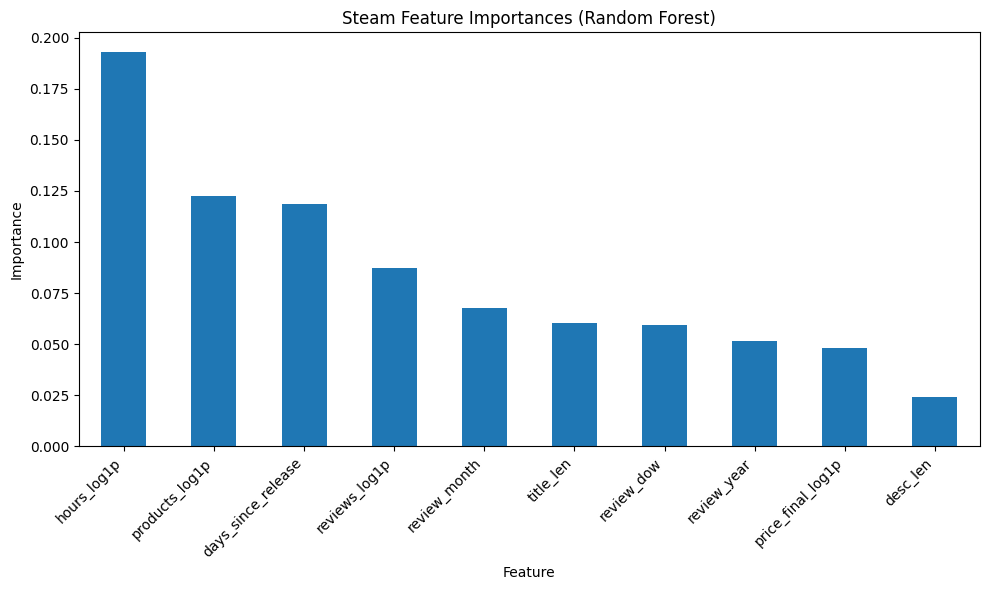

In [6]:
# Baseline steam random forest classifier
from sklearn.ensemble import RandomForestClassifier

rf_steam = RandomForestClassifier(random_state=random_state, n_jobs=1)
steam_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=random_state)
rf_steam_scores = cross_val_score(rf_steam, X_train_steam, y_train_steam, cv=steam_cv, scoring="f1_macro", n_jobs=-1)
print(f"\nSteam Random Forest CV F1 Macro: {rf_steam_scores.mean():.4f} ± {rf_steam_scores.std():.4f}")
rf_steam.fit(X_train_steam, y_train_steam)

steam_X_df = pd.DataFrame(X_train_steam, columns=X_train_steam.columns)
importances = pd.Series(rf_steam.feature_importances_, index=steam_X_df.columns).sort_values(ascending=False)
print("\nTop 10 Steam feature importances:\n", importances.head(10))

importances.head(10).plot(kind="bar", figsize=(10, 6), title="Steam Feature Importances (Random Forest)")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [7]:
param_distributions = {
    "max_depth": range(2, 25, 1),
    "min_samples_split": range(2, 25, 1),
    "min_samples_leaf": range(1, 25, 1),
    "max_features": float_range(0.1, 1.01, 0.1),
}

random_search = RandomizedSearchCV(
    estimator           = DecisionTreeClassifier(random_state=42),
    param_distributions = param_distributions,
    n_iter              = 20,
    cv                  = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42),
    scoring             = "f1_macro",
    random_state        = 42,
    n_jobs              = -1,
    verbose             = 2
)

random_search.fit(X_train_steam, y_train_steam)

# Convert the CV results to a DataFrame
results_df = pd.DataFrame(random_search.cv_results_)

results_df["f1_macro"] = results_df["mean_test_score"]

# Sort by mean test score (descending) and get the top 5 models
top5 = results_df.sort_values(by="f1_macro", ascending=False).head(5)

print("\nTop 5 Randomized Search Results (Decision Tree):")
print(top5[["f1_macro", "std_test_score", "params"]])
print("Best parameters:", random_search.best_params_)
print("Best CV F1 Macro: {:.3f}".format(random_search.best_score_))

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END max_depth=24, max_features=0.1, min_samples_leaf=23, min_samples_split=14; total time=   0.2s
[CV] END max_depth=24, max_features=0.1, min_samples_leaf=23, min_samples_split=14; total time=   0.2s
[CV] END max_depth=24, max_features=0.1, min_samples_leaf=23, min_samples_split=14; total time=   0.2s
[CV] END max_depth=24, max_features=0.1, min_samples_leaf=23, min_samples_split=14; total time=   0.2s
[CV] END max_depth=4, max_features=0.8999999999999999, min_samples_leaf=15, min_samples_split=19; total time=   0.4s
[CV] END max_depth=4, max_features=0.8999999999999999, min_samples_leaf=15, min_samples_split=19; total time=   0.4s
[CV] END max_depth=4, max_features=0.8999999999999999, min_samples_leaf=15, min_samples_split=19; total time=   0.4s
[CV] END max_depth=4, max_features=0.8999999999999999, min_samples_leaf=15, min_samples_split=19; total time=   0.4s
[CV] END max_depth=4, max_features=0.8999999999999999, mi

In [8]:
param_distributions = {
    "n_estimators": range(100, 501, 100),
    "max_depth": range(2, 25, 1),
    "min_samples_split": range(2, 25, 1),
    "min_samples_leaf": range(1, 25, 1),
    "max_features": float_range(0.1, 1.01, 0.1),
}

random_search = RandomizedSearchCV(
    estimator           = RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions = param_distributions,
    n_iter              = 20,
    cv                  = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42),
    scoring             = "f1_macro",
    random_state        = 42,
    n_jobs              = 1,
    verbose             = 2
)

random_search.fit(X_train_steam, y_train_steam)

# Convert the CV results to a DataFrame
results_df = pd.DataFrame(random_search.cv_results_)

results_df["f1_macro"] = results_df["mean_test_score"]

# Sort by mean test score (descending) and get the top 5 models
top5 = results_df.sort_values(by="f1_macro", ascending=False).head(5)

print("\nTop 5 Randomized Search Results (Random Forest):")
print(top5[["f1_macro", "std_test_score", "params"]])
print("Best parameters:", random_search.best_params_)
print("Best CV F1 Macro: {:.3f}".format(random_search.best_score_))

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END max_depth=6, max_features=0.5, min_samples_leaf=5, min_samples_split=13, n_estimators=400; total time=   7.8s
[CV] END max_depth=6, max_features=0.5, min_samples_leaf=5, min_samples_split=13, n_estimators=400; total time=   7.7s
[CV] END max_depth=6, max_features=0.5, min_samples_leaf=5, min_samples_split=13, n_estimators=400; total time=   7.4s
[CV] END max_depth=6, max_features=0.5, min_samples_leaf=5, min_samples_split=13, n_estimators=400; total time=   7.4s
[CV] END max_depth=6, max_features=0.5, min_samples_leaf=5, min_samples_split=13, n_estimators=400; total time=   7.5s
[CV] END max_depth=6, max_features=0.5, min_samples_leaf=5, min_samples_split=13, n_estimators=400; total time=   7.7s
[CV] END max_depth=6, max_features=0.5, min_samples_leaf=5, min_samples_split=13, n_estimators=400; total time=   7.4s
[CV] END max_depth=6, max_features=0.5, min_samples_leaf=5, min_samples_split=13, n_estimators=400; tota

# Olist Transactions


Olist Decision Tree CV F1 Macro: 0.9816 ± 0.0012

Top 10 Olist feature importances:
 product_description_lenght   0.111245
density_g_per_cm3            0.099980
price                        0.080542
product_weight_g             0.080308
product_name_lenght          0.077274
seller_zip_code_prefix       0.075065
product_volume_cm3           0.068337
product_length_cm            0.062586
seller_city_freq             0.062109
product_width_cm             0.060101
dtype: float64


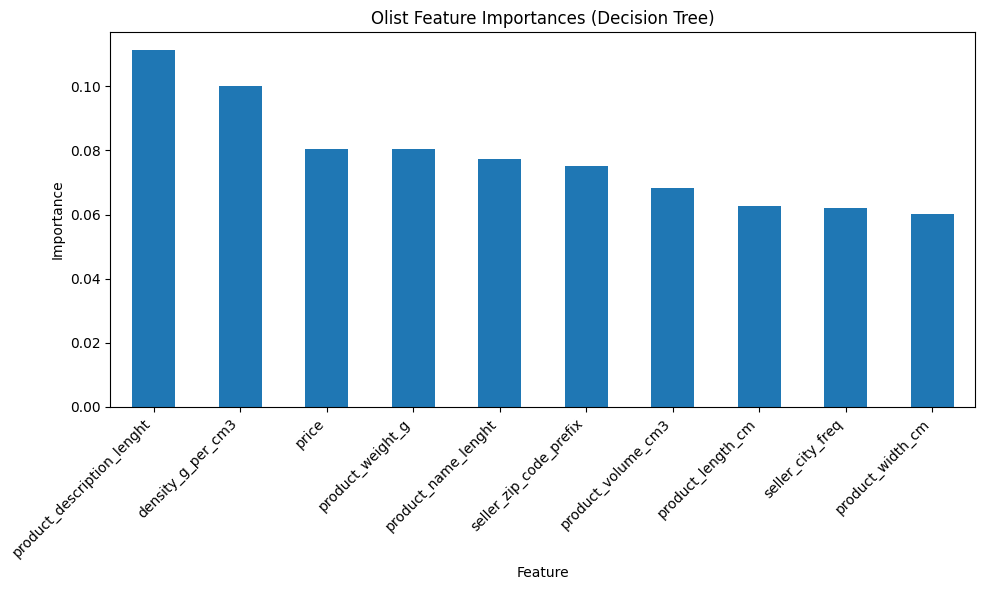

In [9]:
# Baseline Olist decision tree classifier

dt_olist = DecisionTreeClassifier(random_state=random_state)
olist_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=random_state)
dt_olist_scores = cross_val_score(dt_olist, X_train_olist, y_train_olist, cv=olist_cv, scoring="f1_macro", n_jobs=-1)
print(f"\nOlist Decision Tree CV F1 Macro: {dt_olist_scores.mean():.4f} ± {dt_olist_scores.std():.4f}")
dt_olist.fit(X_train_olist, y_train_olist)

olist_X_df = pd.DataFrame(X_train_olist, columns=X_train_olist.columns)
importances = pd.Series(dt_olist.feature_importances_, index=olist_X_df.columns).sort_values(ascending=False)
print("\nTop 10 Olist feature importances:\n", importances.head(10))

importances.head(10).plot(kind="bar", figsize=(10, 6), title="Olist Feature Importances (Decision Tree)")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


olist Random Forest CV F1 Macro: 0.9936 ± 0.0006

Top 10 Olist feature importances:
 product_description_lenght   0.081601
density_g_per_cm3            0.073631
product_volume_cm3           0.067101
product_weight_g             0.065420
seller_zip_code_prefix       0.063517
price                        0.060962
product_name_lenght          0.060004
seller_city_freq             0.053526
product_height_cm            0.050479
product_width_cm             0.050204
dtype: float64


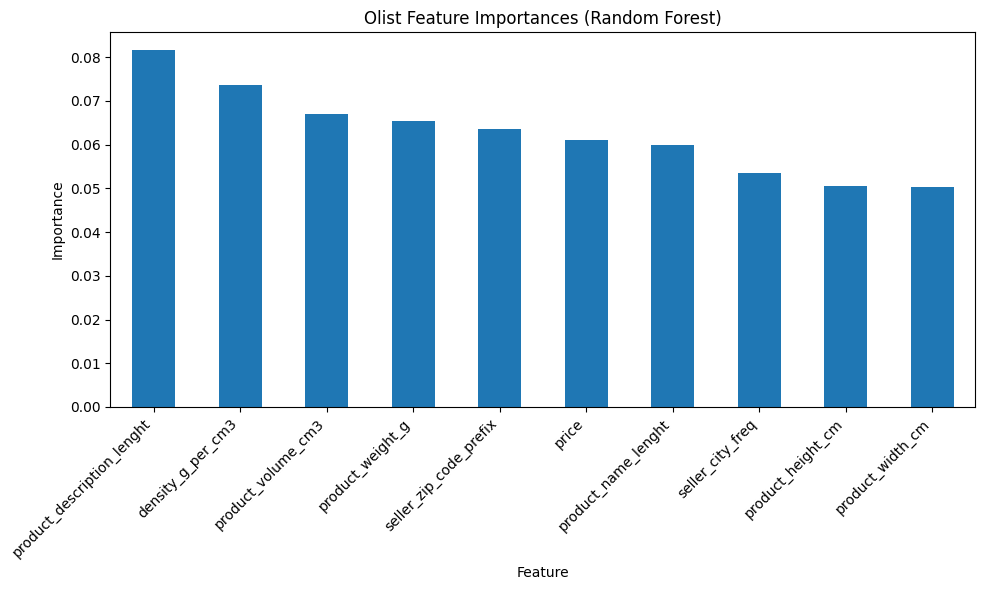

In [10]:
# Baseline Olist random forest classifier
from sklearn.ensemble import RandomForestClassifier

rf_olist = RandomForestClassifier(random_state=random_state, n_jobs=1)
olist_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=random_state)
rf_olist_scores = cross_val_score(rf_olist, X_train_olist, y_train_olist, cv=olist_cv, scoring="f1_macro", n_jobs=-1)
print(f"\nolist Random Forest CV F1 Macro: {rf_olist_scores.mean():.4f} ± {rf_olist_scores.std():.4f}")
rf_olist.fit(X_train_olist, y_train_olist)

olist_X_df = pd.DataFrame(X_train_olist, columns=X_train_olist.columns)
importances = pd.Series(rf_olist.feature_importances_, index=olist_X_df.columns).sort_values(ascending=False)
print("\nTop 10 Olist feature importances:\n", importances.head(10))

importances.head(10).plot(kind="bar", figsize=(10, 6), title="Olist Feature Importances (Random Forest)")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [11]:
param_distributions = {
    "max_depth": range(2, 25, 1),
    "min_samples_split": range(2, 25, 1),
    "min_samples_leaf": range(1, 25, 1),
    "max_features": float_range(0.1, 1.01, 0.1),
}

random_search = RandomizedSearchCV(
    estimator           = DecisionTreeClassifier(random_state=42),
    param_distributions = param_distributions,
    n_iter              = 20,
    cv                  = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42),
    scoring             = "f1_macro",
    random_state        = 42,
    n_jobs              = -1,
    verbose             = 2
)

random_search.fit(X_train_olist, y_train_olist)

# Convert the CV results to a DataFrame
results_df = pd.DataFrame(random_search.cv_results_)

results_df["f1_macro"] = results_df["mean_test_score"]

# Sort by mean test score (descending) and get the top 5 models
top5 = results_df.sort_values(by="f1_macro", ascending=False).head(5)

print("\nTop 5 Randomized Search Results (Decision Tree):")
print(top5[["f1_macro", "std_test_score", "params"]])
print("Best parameters:", random_search.best_params_)
print("Best CV F1 Macro: {:.3f}".format(random_search.best_score_))

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END max_depth=24, max_features=0.1, min_samples_leaf=23, min_samples_split=14; total time=   0.3s
[CV] END max_depth=24, max_features=0.1, min_samples_leaf=23, min_samples_split=14; total time=   0.3s
[CV] END max_depth=24, max_features=0.1, min_samples_leaf=23, min_samples_split=14; total time=   0.3s
[CV] END max_depth=24, max_features=0.1, min_samples_leaf=23, min_samples_split=14; total time=   0.3s
[CV] END max_depth=24, max_features=0.1, min_samples_leaf=23, min_samples_split=14; total time=   0.3s
[CV] END max_depth=24, max_features=0.1, min_samples_leaf=23, min_samples_split=14; total time=   0.3s
[CV] END max_depth=24, max_features=0.1, min_samples_leaf=23, min_samples_split=14; total time=   0.3s
[CV] END max_depth=24, max_features=0.1, min_samples_leaf=23, min_samples_split=14; total time=   0.3s
[CV] END max_depth=24, max_features=0.1, min_samples_leaf=23, min_samples_split=14; total time=   0.3s
[CV] END m

In [12]:
param_distributions = {
    "n_estimators": range(100, 501, 100),
    "max_depth": range(2, 25, 1),
    "min_samples_split": range(2, 25, 1),
    "min_samples_leaf": range(1, 25, 1),
    "max_features": float_range(0.1, 1.01, 0.1),
}

random_search = RandomizedSearchCV(
    estimator           = RandomForestClassifier(random_state=42, n_jobs=1),
    param_distributions = param_distributions,
    n_iter              = 20,
    cv                  = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42),
    scoring             = "f1_macro",
    random_state        = 42,
    n_jobs              = -1,
    verbose             = 2
)

random_search.fit(X_train_olist, y_train_olist)

# Convert the CV results to a DataFrame
results_df = pd.DataFrame(random_search.cv_results_)

results_df["f1_macro"] = results_df["mean_test_score"]

# Sort by mean test score (descending) and get the top 5 models
top5 = results_df.sort_values(by="f1_macro", ascending=False).head(5)

print("\nTop 5 Randomized Search Results (Random Forest):")
print(top5[["f1_macro", "std_test_score", "params"]])
print("Best parameters:", random_search.best_params_)
print("Best CV F1 Macro: {:.3f}".format(random_search.best_score_))

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END max_depth=6, max_features=0.5, min_samples_leaf=5, min_samples_split=13, n_estimators=400; total time= 2.3min
[CV] END max_depth=6, max_features=0.5, min_samples_leaf=5, min_samples_split=13, n_estimators=400; total time= 2.3min
[CV] END max_depth=6, max_features=0.5, min_samples_leaf=5, min_samples_split=13, n_estimators=400; total time= 2.3min
[CV] END max_depth=6, max_features=0.5, min_samples_leaf=5, min_samples_split=13, n_estimators=400; total time= 2.3min
[CV] END max_depth=6, max_features=0.5, min_samples_leaf=5, min_samples_split=13, n_estimators=400; total time= 2.3min
[CV] END max_depth=6, max_features=0.5, min_samples_leaf=5, min_samples_split=13, n_estimators=400; total time= 2.3min
[CV] END max_depth=6, max_features=0.5, min_samples_leaf=5, min_samples_split=13, n_estimators=400; total time= 2.3min
[CV] END max_depth=6, max_features=0.5, min_samples_leaf=5, min_samples_split=13, n_estimators=400; tota

# Video Game Sales


Sales Decision Tree CV F1 Macro: 0.9966 ± 0.0004

Top 10 Sales feature importances:
 Year                    0.261328
ESRB_Rating_Unknown     0.174213
Developer_freq          0.145540
Publisher_freq          0.124780
ESRB_Rating_E           0.042705
Platform_Family_PC      0.025342
Genre_Sports            0.018441
Platform_Family_Xbox    0.017238
Genre_Platform          0.016925
Platform_Family_Other   0.016191
dtype: float64


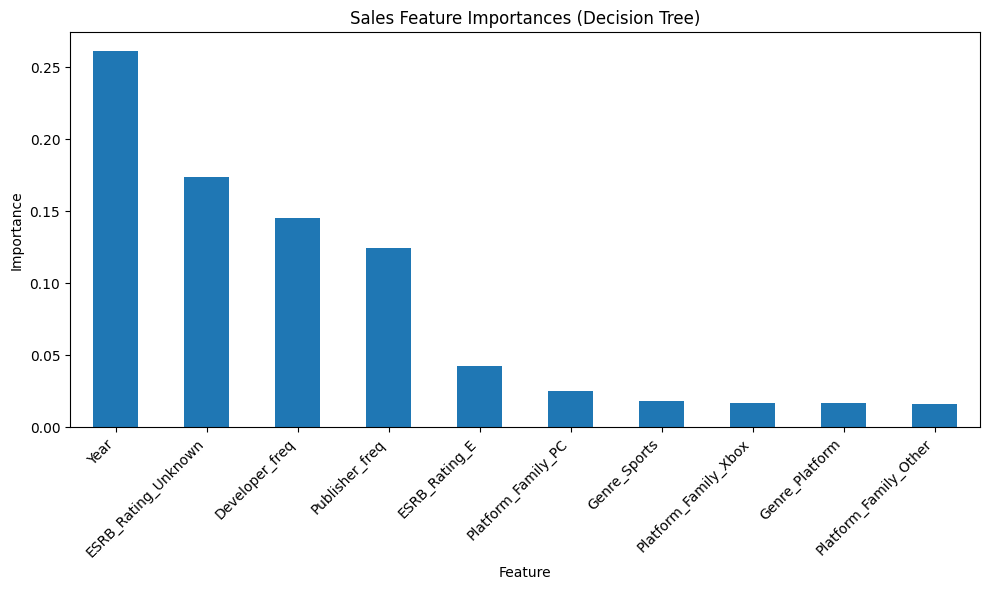

In [13]:
# Baseline Sales decision tree classifier

dt_sales = DecisionTreeClassifier(random_state=random_state)
sales_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=random_state)
dt_sales_scores = cross_val_score(dt_sales, X_train_sales, y_train_sales, cv=sales_cv, scoring="f1_macro", n_jobs=-1)
print(f"\nSales Decision Tree CV F1 Macro: {dt_sales_scores.mean():.4f} ± {dt_sales_scores.std():.4f}")
dt_sales.fit(X_train_sales, y_train_sales)

sales_X_df = pd.DataFrame(X_train_sales, columns=X_train_sales.columns)
importances = pd.Series(dt_sales.feature_importances_, index=sales_X_df.columns).sort_values(ascending=False)
print("\nTop 10 Sales feature importances:\n", importances.head(10))

importances.head(10).plot(kind="bar", figsize=(10, 6), title="Sales Feature Importances (Decision Tree)")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Sales Random Forest CV F1 Macro: 0.9981 ± 0.0003

Top 10 Sales feature importances:
 Year                  0.178510
Developer_freq        0.148442
Publisher_freq        0.131380
ESRB_Rating_Unknown   0.092715
Genre_Misc            0.033415
ESRB_Rating_T         0.033297
ESRB_Rating_M         0.030776
Genre_Role-Playing    0.030452
Platform_Family_PC    0.024519
is_portable           0.022892
dtype: float64


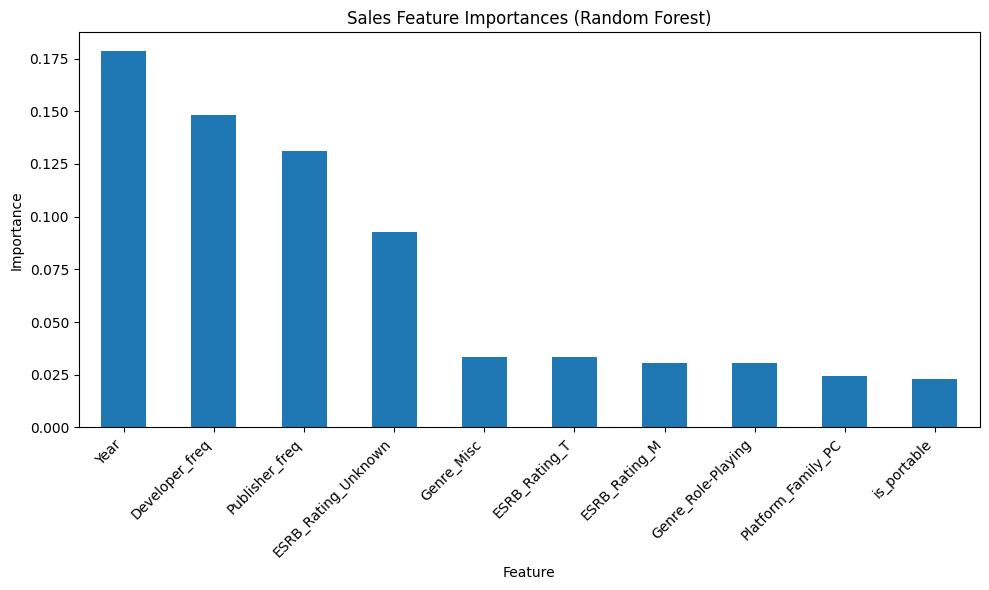

In [14]:
# Baseline Sales random forest classifier
from sklearn.ensemble import RandomForestClassifier

rf_sales = RandomForestClassifier(random_state=random_state, n_jobs=1)
sales_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=random_state)
rf_sales_scores = cross_val_score(rf_sales, X_train_sales, y_train_sales, cv=sales_cv, scoring="f1_macro", n_jobs=-1)
print(f"\nSales Random Forest CV F1 Macro: {rf_sales_scores.mean():.4f} ± {rf_sales_scores.std():.4f}")
rf_sales.fit(X_train_sales, y_train_sales)

sales_X_df = pd.DataFrame(X_train_sales, columns=X_train_sales.columns)
importances = pd.Series(rf_sales.feature_importances_, index=sales_X_df.columns).sort_values(ascending=False)
print("\nTop 10 Sales feature importances:\n", importances.head(10))

importances.head(10).plot(kind="bar", figsize=(10, 6), title="Sales Feature Importances (Random Forest)")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [15]:
param_distributions = {
    "max_depth": range(2, 25, 1),
    "min_samples_split": range(2, 25, 1),
    "min_samples_leaf": range(1, 25, 1),
    "max_features": float_range(0.1, 1.01, 0.1),
}

random_search = RandomizedSearchCV(
    estimator           = DecisionTreeClassifier(random_state=42),
    param_distributions = param_distributions,
    n_iter              = 20,
    cv                  = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42),
    scoring             = "f1_macro",
    random_state        = 42,
    n_jobs              = -1,
    verbose             = 2
)

random_search.fit(X_train_sales, y_train_sales)

# Convert the CV results to a DataFrame
results_df = pd.DataFrame(random_search.cv_results_)

results_df["f1_macro"] = results_df["mean_test_score"]

# Sort by mean test score (descending) and get the top 5 models
top5 = results_df.sort_values(by="f1_macro", ascending=False).head(5)

print("\nTop 5 Randomized Search Results (Decision Tree):")
print(top5[["f1_macro", "std_test_score", "params"]])
print("Best parameters:", random_search.best_params_)
print("Best CV F1 Macro: {:.3f}".format(random_search.best_score_))


Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END max_depth=24, max_features=0.1, min_samples_leaf=23, min_samples_split=14; total time=   0.0s
[CV] END max_depth=24, max_features=0.1, min_samples_leaf=23, min_samples_split=14; total time=   0.0s
[CV] END max_depth=24, max_features=0.1, min_samples_leaf=23, min_samples_split=14; total time=   0.0s
[CV] END max_depth=24, max_features=0.1, min_samples_leaf=23, min_samples_split=14; total time=   0.0s
[CV] END max_depth=24, max_features=0.1, min_samples_leaf=23, min_samples_split=14; total time=   0.0s
[CV] END max_depth=24, max_features=0.1, min_samples_leaf=23, min_samples_split=14; total time=   0.0s
[CV] END max_depth=24, max_features=0.1, min_samples_leaf=23, min_samples_split=14; total time=   0.0s
[CV] END max_depth=24, max_features=0.1, min_samples_leaf=23, min_samples_split=14; total time=   0.0s
[CV] END max_depth=24, max_features=0.1, min_samples_leaf=23, min_samples_split=14; total time=   0.0s
[CV] END m

In [16]:
param_distributions = {
    "n_estimators": range(100, 501, 100),
    "max_depth": range(2, 25, 1),
    "min_samples_split": range(2, 25, 1),
    "min_samples_leaf": range(1, 25, 1),
    "max_features": float_range(0.1, 1.01, 0.1),
}

random_search = RandomizedSearchCV(
    estimator           = RandomForestClassifier(random_state=42, n_jobs=1),
    param_distributions = param_distributions,
    n_iter              = 20,
    cv                  = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42),
    scoring             = "f1_macro",
    random_state        = 42,
    n_jobs              = -1,
    verbose             = 2
)

random_search.fit(X_train_sales, y_train_sales)

# Convert the CV results to a DataFrame
results_df = pd.DataFrame(random_search.cv_results_)

results_df["f1_macro"] = results_df["mean_test_score"]

# Sort by mean test score (descending) and get the top 5 models
top5 = results_df.sort_values(by="f1_macro", ascending=False).head(5)

print("\nTop 5 Randomized Search Results (Random Forest):")
print(top5[["f1_macro", "std_test_score", "params"]])
print("Best parameters:", random_search.best_params_)
print("Best CV F1 Macro: {:.3f}".format(random_search.best_score_))


Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END max_depth=6, max_features=0.5, min_samples_leaf=5, min_samples_split=13, n_estimators=400; total time=  13.7s
[CV] END max_depth=6, max_features=0.5, min_samples_leaf=5, min_samples_split=13, n_estimators=400; total time=  13.7s
[CV] END max_depth=6, max_features=0.5, min_samples_leaf=5, min_samples_split=13, n_estimators=400; total time=  13.7s
[CV] END max_depth=6, max_features=0.5, min_samples_leaf=5, min_samples_split=13, n_estimators=400; total time=  13.8s
[CV] END max_depth=6, max_features=0.5, min_samples_leaf=5, min_samples_split=13, n_estimators=400; total time=  13.8s
[CV] END max_depth=6, max_features=0.5, min_samples_leaf=5, min_samples_split=13, n_estimators=400; total time=  13.9s
[CV] END max_depth=6, max_features=0.5, min_samples_leaf=5, min_samples_split=13, n_estimators=400; total time=  13.8s
[CV] END max_depth=6, max_features=0.5, min_samples_leaf=5, min_samples_split=13, n_estimators=400; tota